In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
replace dataset/test/BELUM SIAP/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
import seaborn as sns
from tensorflow import keras
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import cv2 as cv
import time
from skimage import io, measure
from scipy import ndimage
from skimage.color import label2rgb

In [ ]:
def convert_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return hours, minutes, seconds

In [ ]:
# def show_image_samples(generated_data):
#     class_indices = generated_data.class_indices
#     class_ = list(class_indices.keys())
#     imgs, labels = generated_data.next()
#     plt.figure(figsize=(20, 20))
#     length = len(labels)
#     r = length if length < 25 else 25

#     for i in range(r):
#         plt.subplot(5, 5, i + 1)
#         plt.imshow(imgs[i], cmap='gray')
#         idx = int(labels[i])
#         c_name = classes[idx]
#         plt.title(c_name, color='Blue', fontsize=16)
#         plt.axis('off')
#     plt.show()


def show_image_samples(generated_data):
    class_indices = generated_data.class_indices
    classes = list(class_indices.keys())  # Ensure you have the correct class names
    imgs, labels = next(iter(generated_data))  # Fetch the next batch of images and labels
    plt.figure(figsize=(20, 20))
    num_samples = min(len(labels), 25)  # Display up to 25 samples

    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(imgs[i])  # No need for cmap='gray' for RGB images
        idx = int(labels[i])
        c_name = classes[idx]
        plt.title(c_name, color='blue', fontsize=16)
        plt.axis('off')

    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()


In [ ]:
# path = '/kaggle/input/mustard-leaf-prediction/mustard-leaf-dataset'
test_path = '/content/dataset/test'
path = '/content/dataset/'
classes = [x for x in os.listdir(os.path.join(path, 'train'))]
classes

['Yellow_rust', 'Brown_rust', 'BELUM SIAP', 'SIAP PANEN', 'Healthy']

In [ ]:
def overlay(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv, (10, 30,  30), (90, 255, 255))
    closed_mask = ndimage.binary_closing(mask, np.ones((7, 7)))
    label_img = measure.label(closed_mask)
    return label2rgb(label_img, image=image)


In [ ]:
def overlay():
    def green_overlay(image):
#         image = io.imread(image)
        image = image.copy()
        hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
        mask = cv.inRange(hsv, (40, 150,  20), (90, 255, 255))
        green_objects = cv.bitwise_and(image, image, mask=mask)
        print(mask)

        return cv.cvtColor(green_objects, cv.COLOR_BGR2RGB)
    return green_overlay


In [ ]:
bs = 8

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=.25,
)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
data_train = image_gen.flow_from_directory(
    os.path.join(path, 'train'),
    target_size=(224, 224),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    subset='training',
    class_mode='sparse',
    shuffle=True
)

data_val = image_gen.flow_from_directory(
    os.path.join(path, 'train'),
    target_size=(224, 224),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    subset='validation',
    class_mode='sparse',
    shuffle=True
)

data_test = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=bs,
    color_mode='rgb',
    classes=classes,
    class_mode='sparse',
    seed=224,
    shuffle=False
)

Found 3557 images belonging to 5 classes.
Found 1185 images belonging to 5 classes.
Found 917 images belonging to 5 classes.


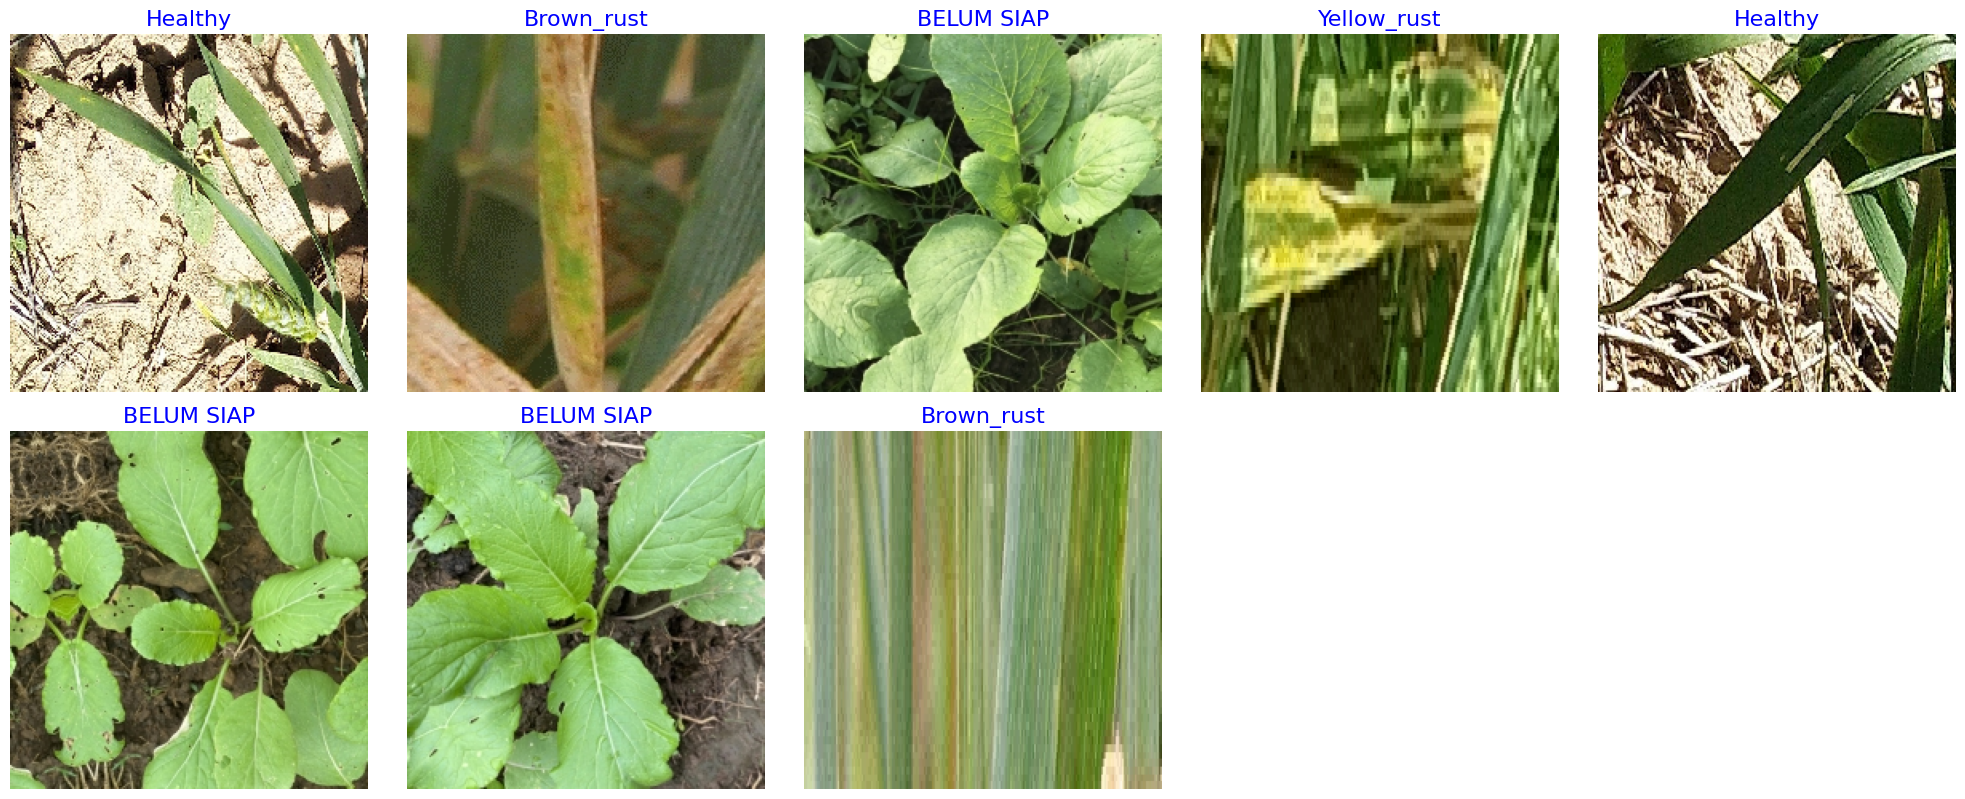

In [ ]:
show_image_samples(data_train)

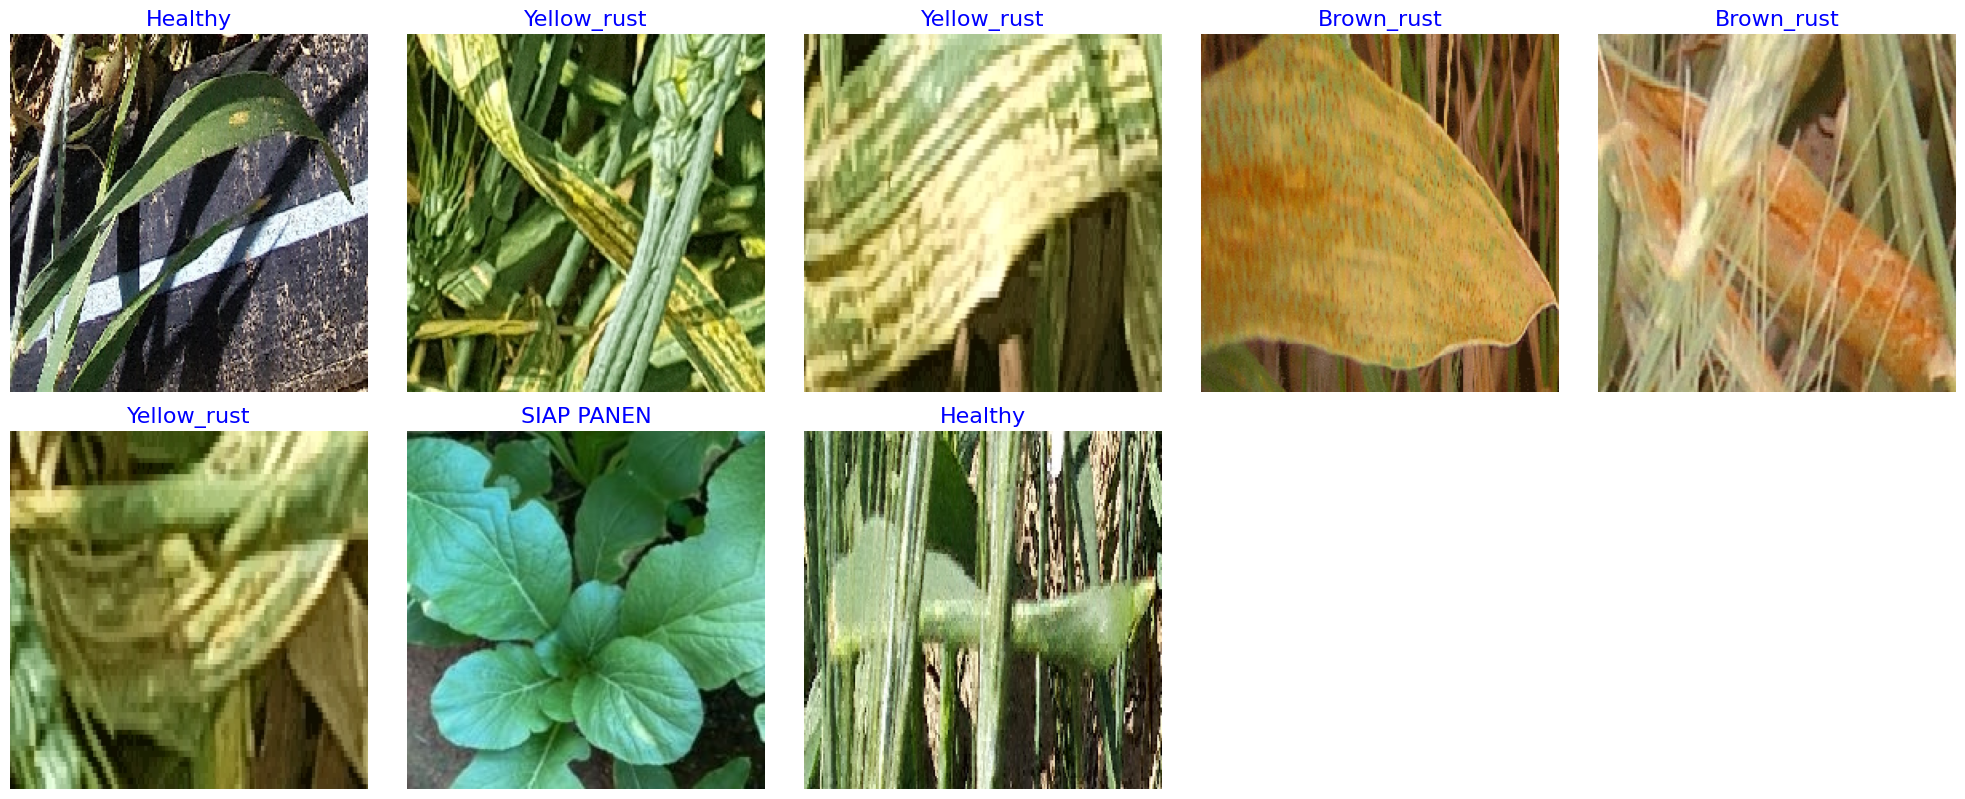

In [ ]:
show_image_samples(data_val)

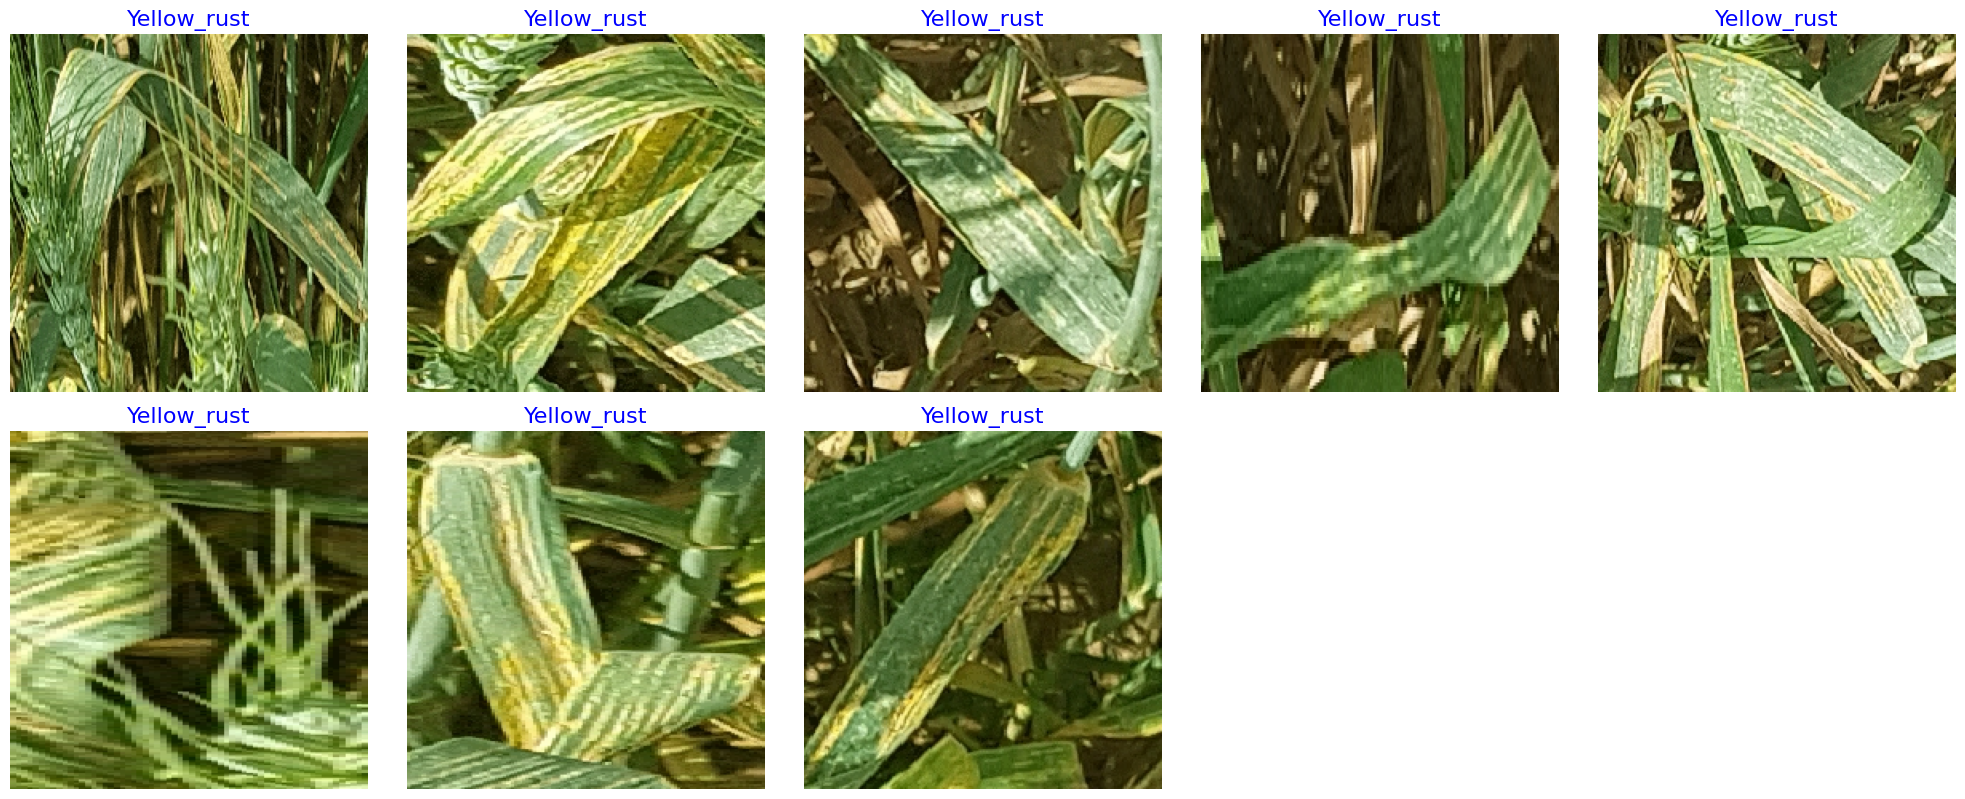

In [ ]:
show_image_samples(data_test)

In [ ]:
basemodel = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=keras.layers.Input(shape=(224, 224, 3)),
#     pooling='max',
#     classes=len(classes),
#     classifier_activation="softmax",
)
basemodel.summary()
model = keras.models.Sequential([
    basemodel,

    keras.layers.Conv2D(32, (3, 3), activation='relu', strides=1),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(classes), activation='softmax'),
])

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Flatten(),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras import optimizers

model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],  # Pass metrics as a list
    optimizer=optimizers.Adam(learning_rate=0.0001)
)


# model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy', optimizer=keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1577088)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │      15,770,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,771,786 (60.16 MB)

 Trainable params: 15,771,786 (60.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

In [ ]:
H = model.fit(
    data_train,
    validation_data=data_val,
    epochs=40,
    validation_steps=data_val.n // data_val.batch_size,
    steps_per_epoch=data_train.n // data_train.batch_size,
    batch_size=bs
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


444/444 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.5249 - loss: 3.6391 - val_accuracy: 0.6791 - val_loss: 1.1124
Epoch 2/40
  1/444 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8750 - loss: 0.6361

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8750 - loss: 0.6361 - val_accuracy: 0.0000e+00 - val_loss: 1.8204
Epoch 3/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8808 - loss: 0.3699 - val_accuracy: 0.7855 - val_loss: 0.6812
Epoch 4/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.8750 - loss: 0.2045 - val_accuracy: 1.0000 - val_loss: 0.6635
Epoch 5/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9578 - loss: 0.1131 - val_accuracy: 0.8429 - val_loss: 0.3828
Epoch 6/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.8750 - loss: 0.1452 - val_accuracy: 0.0000e+00 - val_loss: 3.5496
Epoch 7/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9905 - loss: 0.0454 - val_accuracy: 0.8488 - val_loss: 0.3952
Epoch 8/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 9/40
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9997 - loss: 0.0221 - val_accu

In [ ]:
end_time = time.time()
h, m, s = convert_seconds(end_time - start_time)
final_time = f"{int(h)} Jam {int(m)} Menit {round(s, 3)} Detik"
final_time

'0 Jam 6 Menit 42.838 Detik'

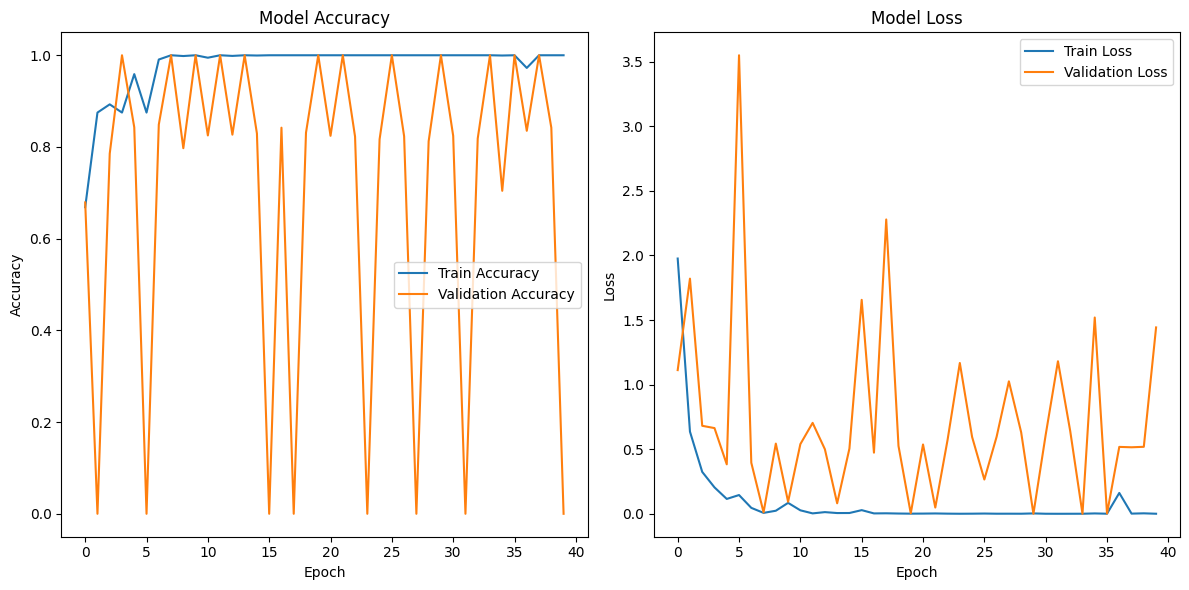

In [ ]:
# plt.plot(np.arange(1, N), H.history["loss"], label="Training loss")
# plt.plot(np.arange(1, N), H.history["val_loss"], label="Validation loss")
# plt.title("Loss")
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt

# Assume H is the history object returned by model.fit
# Extract the history dictionary
history = H.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# plt.plot(np.arange(1, N), H.history["accuracy"], label="Training accuracy")
# plt.plot(np.arange(1, N), H.history["val_accuracy"], label="Validation Accuracy")
# plt.title("Accuracy Score")
# plt.legend()

# plt.show()

In [ ]:
# N = 41

# fig, ax = plt.subplots(2, 1, figsize=(12, 10))
# ax = ax.flatten()

# ax[0].plot(np.arange(1, N), H.history["loss"], label="Training loss")
# ax[0].plot(np.arange(1, N), H.history["val_loss"], label="Validation loss")
# ax[0].title.set_text("Loss")
# ax[0].legend()

# ax[1].plot(np.arange(1, N), H.history["accuracy"], label="Training accuracy")
# ax[1].plot(np.arange(1, N), H.history["val_accuracy"], label="Validation Accuracy")
# ax[1].title.set_text("Accuracy Score")
# ax[1].legend()

# plt.show()

In [ ]:
prediction = model.predict(data_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


In [ ]:
model.evaluate(data_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9358 - loss: 0.2310


[0.25498172640800476, 0.9312977194786072]

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


<Figure size 1000x700 with 0 Axes>

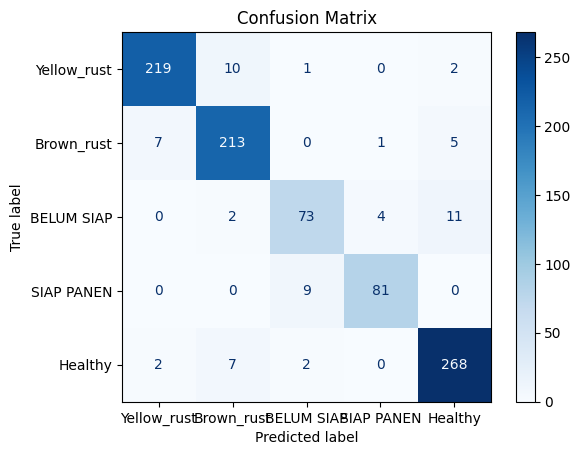

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = data_test.classes
y_pred = np.argmax(model.predict(data_test), axis=-1)

# Get class indices and labels
class_indices = data_test.class_indices
class_labels = sorted(class_indices, key=class_indices.get)  # Ensure consistent order

# Create a mapping from indices to class labels
index_to_label = {index: label for label, index in class_indices.items()}
y_true_labels = [index_to_label[index] for index in y_true]
y_pred_labels = [index_to_label[index] for index in y_pred]

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'Yellow_rust': {'precision': 0.9605263157894737, 'recall': 0.9439655172413793, 'f1-score': 0.9521739130434783, 'support': 232.0}, 'Brown_rust': {'precision': 0.9181034482758621, 'recall': 0.9424778761061947, 'f1-score': 0.9301310043668122, 'support': 226.0}, 'BELUM SIAP': {'precision': 0.8588235294117647, 'recall': 0.8111111111111111, 'f1-score': 0.8342857142857144, 'support': 90.0}, 'SIAP PANEN': {'precision': 0.9418604651162791, 'recall': 0.9, 'f1-score': 0.9204545454545455, 'support': 90.0}, 'Healthy': {'precision': 0.9370629370629371, 'recall': 0.9605734767025089, 'f1-score': 0.9486725663716814, 'support': 279.0}, 'accuracy': 0.9312977099236641, 'macro avg': {'precision': 0.9232753391312633, 'recall': 0.9116255962322388, 'f1-score': 0.9171435487044464, 'support': 917.0}, 'weighted avg': {'precision': 0.9311184335022749, 'recall': 0.9312977099236641, 'f1-score': 0.9309926109130959, 'support': 917.0}}


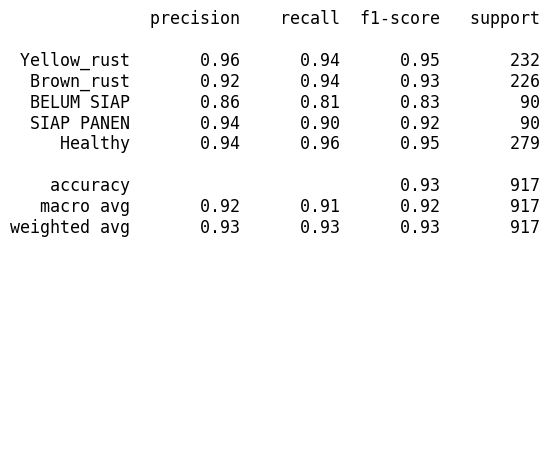

In [ ]:
plt.subplot(1, 2, 2)
plt.axis('off')
report_str = classification_report(y_true, y_pred, target_names=class_labels)
plt.text(0, 1, report_str, {'fontsize': 12}, fontproperties='monospace')

# Adjust layout for better fit
plt.tight_layout()
plt.show()

In [ ]:
# x=np.concatenate([data_test.next()[0] for i in range(data_test.__len__())])
# y=np.concatenate([data_test.next()[1] for i in range(data_test.__len__())])
# print(x.shape)
# print(y.shape)

In [ ]:
# pred_cat = np.argmax(prediction, axis=1)


In [ ]:
# f

In [ ]:
# sns.heatmap(mat, cmap="BuPu", annot=True, fmt="d")
# plt.title("Confusion Matrix", size=15)
# plt.show()

In [ ]:
# print(classification_report(pred_cat, y))